# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy import stats
from statsmodels.stats.weightstats import ztest

In [3]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [4]:
hospital_read_df.head()

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,FROEDTERT MEMORIAL LUTHERAN HOSPITAL,520177,WI,READM-30-HIP-KNEE-HRRP,242,NaN,1.9095,10.8,5.6,38.0,07/01/2010,06/30/2013
1,PROVIDENCE HOSPITAL,90006,DC,READM-30-HIP-KNEE-HRRP,247,NaN,1.7521,9.2,5.3,33.0,07/01/2010,06/30/2013
2,BEAUFORT COUNTY MEMORIAL HOSPITAL,420067,SC,READM-30-HIP-KNEE-HRRP,586,NaN,1.5836,7.6,4.8,53.0,07/01/2010,06/30/2013
3,ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER,140208,IL,READM-30-HIP-KNEE-HRRP,965,NaN,1.5760,9.0,5.7,95.0,07/01/2010,06/30/2013
4,BRAZOSPORT REGIONAL HEALTH SYSTEM,450072,TX,READM-30-HIP-KNEE-HRRP,149,NaN,1.5308,8.2,5.4,20.0,07/01/2010,06/30/2013


In [5]:
hospital_read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 12 columns):
Hospital Name                 16860 non-null object
Provider Number               16860 non-null int64
State                         16860 non-null object
Measure Name                  16860 non-null object
Number of Discharges          16860 non-null object
Footnote                      3129 non-null float64
Excess Readmission Ratio      13731 non-null float64
Predicted Readmission Rate    13731 non-null float64
Expected Readmission Rate     13731 non-null float64
Number of Readmissions        11497 non-null float64
Start Date                    16860 non-null object
End Date                      16860 non-null object
dtypes: float64(5), int64(1), object(6)
memory usage: 1.5+ MB


In [6]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
int_discharges = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df.loc[:, 'Number of Discharges'] = int_discharges
#clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

C:\Users\rammu_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


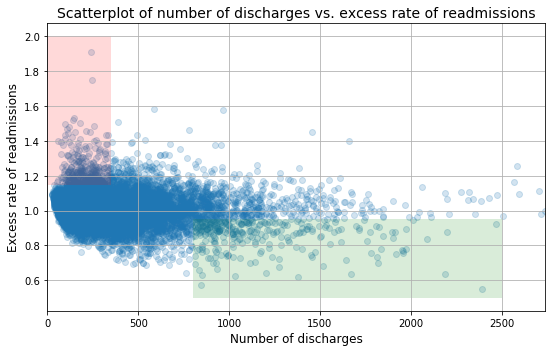

In [7]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

# Question: A. Do you agree with the above analysis and recommendations? Why or why not?

I don't agree with the above analysis and recommendations. There is not enough data to convince us that number of discharges is the main reason for rise in re-admissions. Also, there is no data about the size of the hospitals. We can't assume that smaller number of discharges indicate the smaller size of the hospital. There maybe other factors in play that influence the number of re-admissions.

# Get basic details about the data

In [15]:
df = clean_hospital_read_df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11578 entries, 16857 to 13666
Data columns (total 12 columns):
Hospital Name                 11578 non-null object
Provider Number               11578 non-null int64
State                         11578 non-null object
Measure Name                  11578 non-null object
Number of Discharges          11578 non-null int32
Footnote                      81 non-null float64
Excess Readmission Ratio      11497 non-null float64
Predicted Readmission Rate    11497 non-null float64
Expected Readmission Rate     11497 non-null float64
Number of Readmissions        11497 non-null float64
Start Date                    11578 non-null object
End Date                      11578 non-null object
dtypes: float64(5), int32(1), int64(1), object(5)
memory usage: 1.1+ MB


In [16]:
# In the above dataframe clean_hospital_read_df is not really clean! It has "Number of Discharges" as 0 with corresponding
# Excess Readmission Ratio as "NaN". So, let's remove such rows to calculate t-statistic and p value correctly.
df = df[df['Number of Discharges'] != 0]
df.head()

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
1832,UNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER,210035,MD,READM-30-AMI-HRRP,25,NaN,1.0914,26.8,24.6,12.0,07/01/2010,06/30/2013
1699,ATLANTIC GENERAL HOSPITAL,210061,MD,READM-30-AMI-HRRP,27,NaN,1.0961,24.8,22.6,12.0,07/01/2010,06/30/2013
1774,MERCY MEDICAL CENTER INC,210008,MD,READM-30-AMI-HRRP,28,NaN,1.0934,24.4,22.3,12.0,07/01/2010,06/30/2013
1853,KAISER FOUNDATION HOSPITAL-SANTA CLARA,50071,CA,READM-30-HF-HRRP,29,NaN,1.0908,21.0,19.3,11.0,07/01/2010,06/30/2013
1290,PALMERTON HOSPITAL,390019,PA,READM-30-AMI-HRRP,30,NaN,1.1123,23.2,20.9,13.0,07/01/2010,06/30/2013


In [18]:
df.describe()

,Provider Number,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions
count,11497.000000,11497.000000,0.0,11497.000000,11497.000000,11497.000000,11497.000000
mean,257571.540141,365.466209,NaN,1.007504,17.984292,17.865695,63.633731
std,154274.374018,308.754590,NaN,0.091964,5.487651,5.240749,59.540296
min,10001.000000,25.000000,NaN,0.549500,2.700000,3.900000,11.000000
25%,110129.000000,160.000000,NaN,0.952600,16.300000,16.600000,24.000000
50%,250042.000000,282.000000,NaN,1.003500,19.000000,19.000000,45.000000
75%,390039.000000,474.000000,NaN,1.058100,21.500000,21.400000,82.000000
max,670082.000000,6793.000000,NaN,1.909500,32.800000,28.000000,879.000000


# Question. B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

Compute the correlation Between 'Number of Discharges' and 'Excess Readmission Ratio'

Null Hypothesis: There is no relationship between "Number of Discharges" and "Readmission Ratio".
Alternate Hypothesis: There is a relationship between "Number of Discharges" and "Readmission Ratio".

Significance Level: 99.9% Confidence (alpha = 0.01)

In [21]:
r, pvalue = stats.pearsonr(df['Number of Discharges'], df['Excess Readmission Ratio'])
print('Correlation: {:0.4f},  p-value: {:0.2e}'.format(r, pvalue))

# Print interpretation:
alpha = 0.01
if pvalue > alpha:
    print('Fail to Reject the Null Hypothesis.')
else:
    print('Reject the Null Hypothesis.')

Correlation: -0.0974,  p-value: 1.22e-25
Reject the Null Hypothesis.


Above demonstrates that there is no relationship between number of discharges and excess readmission ratio. Let's try another test.

Execute two sample t-test:

In [22]:
t, p = stats.ttest_ind(df['Number of Discharges'], df['Excess Readmission Ratio'], equal_var=False)
print(t)
print(p)

126.56894236253518
0.0


In [25]:
pvalue = ztest(df['Number of Discharges'], df['Excess Readmission Ratio'])
print(pvalue)

(126.56894236253518, 0.0)


**Both tests above reject the null hypothesis** 

There is no relationship between number of discharges and excess readmission ratio.

Instead of comparing number of discharges vs readmission rate, let's compare number of discharges with readmission ratio

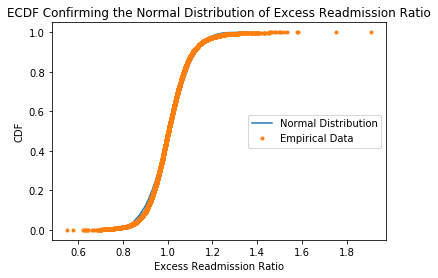

In [26]:
""" Checking if Excess Readmission Ratio is following normal distribution pattern """

# First define a function to compute the CDF:

def cdf(data):
    # Number of data points:
    n = len(data)

    # x-data for the CDF:
    x = np.sort(data)

    # y-data for the CDF:
    y = np.arange(1, n+1) / n

    return x, y

# Compute data to summarize CDF distribution
n = len(df['Excess Readmission Ratio'])
M = np.mean(df['Excess Readmission Ratio'])
s = np.std(df['Excess Readmission Ratio'])

# Make the random numbers predictable using random.seed
np.random.seed(15)

# Simulate a random normal distribution sample with above mean and std and size of 10,000:
normal = np.random.normal(M, s, 10000)

# Now compute the data required to plot ECDF
x_temp, y_temp = cdf(df['Excess Readmission Ratio'])
x_norm, y_norm = cdf(normal)

# Plot both CDFs on the same plot:
plt.plot(x_norm, y_norm)
plt.plot(x_temp, y_temp, marker='.', linestyle='none')

# Add labels, legend, then show the plot
plt.xlabel('Excess Readmission Ratio')
plt.ylabel('CDF')
plt.legend(('Normal Distribution', 'Empirical Data'), loc='center right')
plt.title('ECDF Confirming the Normal Distribution of Excess Readmission Ratio')
plt.show()

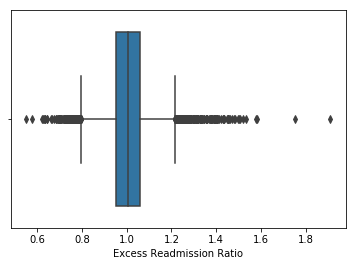

In [27]:
sns.boxplot(x=df['Excess Readmission Ratio'])

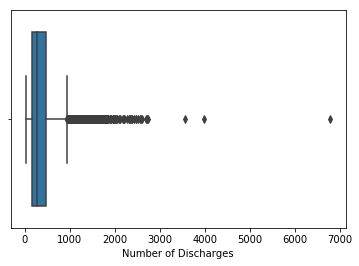

In [28]:
sns.boxplot(x=df['Number of Discharges'])

There are few outliers in both the above cases for number of discharges and readmission ratio.

**Let's try the scatterplot of various variables against readmission ratio.**

In [29]:
df['Measure Name'].value_counts()

READM-30-HF-HRRP          2833
READM-30-PN-HRRP          2789
READM-30-COPD-HRRP        2727
READM-30-AMI-HRRP         1777
READM-30-HIP-KNEE-HRRP    1371
Name: Measure Name, dtype: int64

In [30]:
df['Measure Name'].unique().tolist()

['READM-30-AMI-HRRP',
 'READM-30-HF-HRRP',
 'READM-30-PN-HRRP',
 'READM-30-COPD-HRRP',
 'READM-30-HIP-KNEE-HRRP']

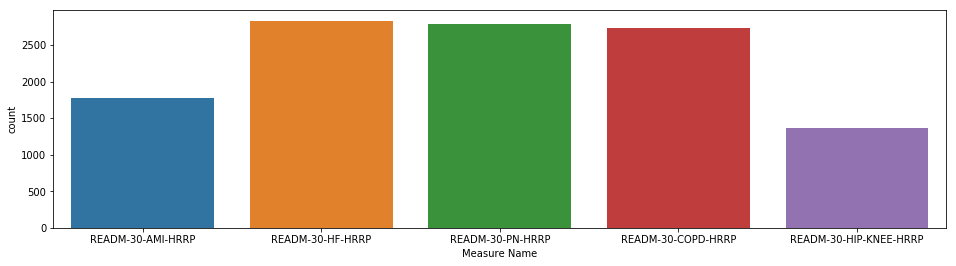

In [31]:
plt.subplots(figsize=(16, 4))
sns.countplot(df['Measure Name']);

C:\Users\rammu_000\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Hip Arthorplasty and Knee Arthroplasty')

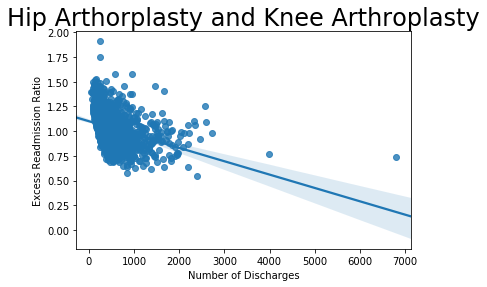

In [32]:
sns.regplot(x="Number of Discharges", y="Excess Readmission Ratio", data=df[df['Measure Name'] == 'READM-30-HIP-KNEE-HRRP']).set_title('Hip Arthorplasty and Knee Arthroplasty', fontsize=24)

Text(0.5, 1.0, 'Chronic Obstructive Pulmonary Disease')

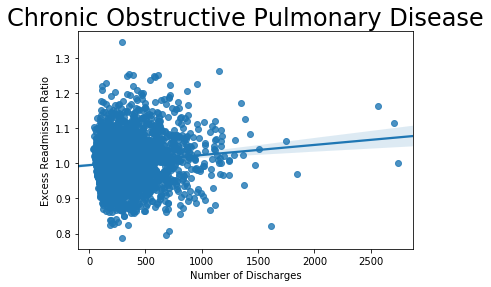

In [33]:
sns.regplot(x="Number of Discharges", y="Excess Readmission Ratio", data=df[df['Measure Name'] == 'READM-30-COPD-HRRP']).set_title('Chronic Obstructive Pulmonary Disease', fontsize=24)

Text(0.5, 1.0, 'Acute Myocardial Infarction')

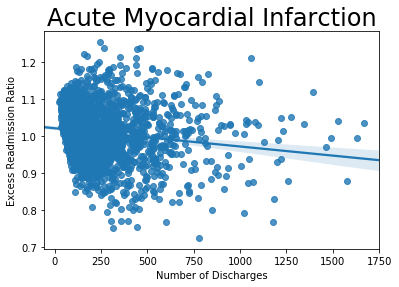

In [34]:
sns.regplot(x="Number of Discharges", y="Excess Readmission Ratio", data=df[df['Measure Name'] == 'READM-30-AMI-HRRP']).set_title('Acute Myocardial Infarction', fontsize=24)

Text(0.5, 1.0, 'Heart Failure')

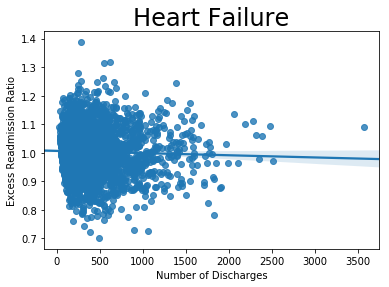

In [35]:
sns.regplot(x="Number of Discharges", y="Excess Readmission Ratio", data=df[df['Measure Name'] == 'READM-30-HF-HRRP']).set_title('Heart Failure', fontsize=24)

Text(0.5, 1.0, 'Pneumonia')

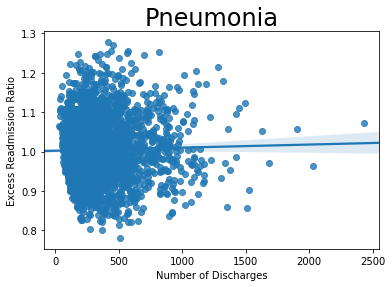

In [36]:
sns.regplot(x="Number of Discharges", y="Excess Readmission Ratio", data=df[df['Measure Name'] == 'READM-30-PN-HRRP']).set_title('Pneumonia', fontsize=24)

As seen from the above charts, different diseases have different set of readmission ratios. "Number of discharges" alone can't be used as an indicator to predict the readmission ratio. People with Pneumonia has equivalent number of chances of getting readmitted irrespective of number of discharges in the given hospital. Patients treated for "Hip and Knee Arthroplasty" seems to be faring well if they are treated in the hospital with higher number of discharges. Maybe some hospitals have specialized surgeons and treatment procedures for "Hip and Knee Arthroplasty". That kind of information is not provided in the data. 

In the absence of more data points, we won't be able to come to solid conclusion about what is causing the readmission ratio to go up.

We also need to understand how many of the patients were alive and live in the same area as of 6/30/2013 because we need to understand why a patient is not readmitted; whether the patient is fully cured or some other life change (like death, relocation, etc.,) happened.

Now, let's try boxplots to see if these give more insights. 

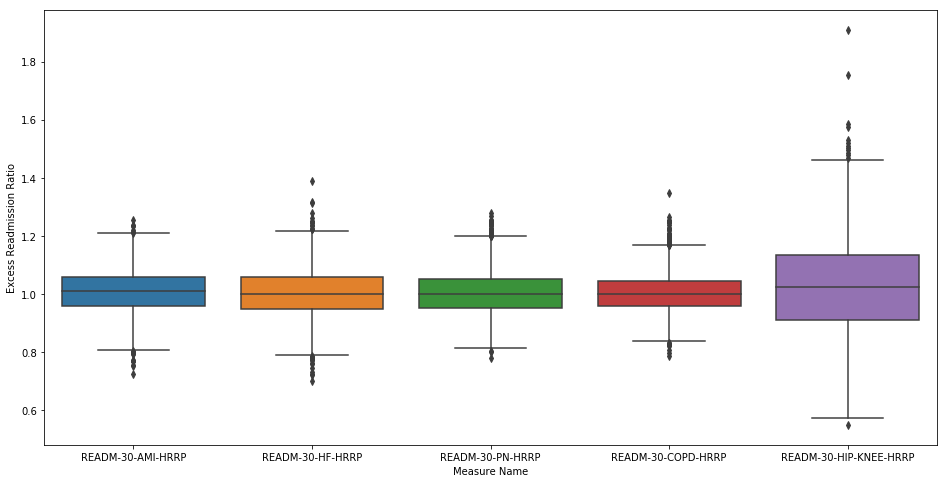

In [37]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='Measure Name', y='Excess Readmission Ratio', data=df);

Above box plot gives more indication that readmission rate varies depending on the disease/treatment type rather than number of discharges in a hospital. This is also proving that we need to get more granular data about specialty of each hospital and the expertise each hospital has for treatment of different health conditions. 

# Summary:

The conclusion in the preliminary report "There is a significant correlation between hospital capacity (number of discharges) and readmission rates. Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions" is incorrect. We don't have enough data to prove this. 

We need more granular data about hospitals, doctors' expertise, treatment sophistication for different health conditions to make better conclusions about what is causing the readmission rate to go up. We also need complete data about patients in terms of if they are alive and live in the same area at the end of data gathering period. 

It's also found that "Measure Name" (type of health condition) is playing more role in readmission rate than the number of discharges. 